In [130]:
import numpy as np
import h5py
%matplotlib inline
from IPython.display import Image
import pandas as pd
import h5py

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

from astropy.io import fits
from astropy.visualization import make_lupton_rgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
#tag = 'gri_cosmos'
tag = 'gri'
base_dir = '/scratch/ksf293/kavli/anomaly'
imarr_fn = f'{base_dir}/data/images_h5/images_{tag}.h5'
results_fn = f'{base_dir}/results/results_{tag}.h5'
imdict_fn = f'{base_dir}/data/idxdicts_h5/idx2imloc_{tag}.npy'
resdict_fn = f'{base_dir}/data/idxdicts_h5/idx2resloc_{tag}.npy'

In [176]:
plot_dir = '../plots/plots_2020-11-20' #intermediate plot dir!
#plot_dir = '../papers/paper_main/images' #use this one when finalized (for this round!)

In [107]:
imarr = h5py.File(imarr_fn, 'r')
res = h5py.File(results_fn, 'r')
print(imarr.keys())
print(res.keys())
print(len(imarr['idxs']))

<KeysViewHDF5 ['idxs', 'images', 'object_ids']>
<KeysViewHDF5 ['anomaly_scores', 'anomaly_scores_norm', 'anomaly_scores_rank', 'disc_scores', 'disc_scores_norm', 'disc_scores_rank', 'gen_scores', 'gen_scores_norm', 'gen_scores_rank', 'idxs', 'object_ids', 'reconstructed']>
942782


# anomaly score distribution

In [5]:
def plot_anomaly_dist(gens, discs, sanoms, title=None, saveto=None):
    
    print(min(gens), max(gens), np.mean(gens), np.std(gens))
    print(min(discs), max(discs), np.mean(discs), np.std(discs))

    minmin = min(min(gens), min(discs))
    maxmax = max(max(gens), max(discs))
    bins = np.linspace(minmin, maxmax, 200)
    
    fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(hspace=0.2)
    
    fig.suptitle(title)

    ax0 = axarr[0]
    b = ax0.hist(gens, bins=bins, alpha=1, color='blue', label='generator \nscore $(s_\mathrm{gen})$', histtype='step')
    b = ax0.hist(discs, bins=bins, alpha=1, color='red', label='discriminator \nscore $(s_\mathrm{disc})$', histtype='step')
    b = ax0.hist(sanoms, bins=bins, alpha=1, color='purple', label='total \nscore $(s_\mathrm{anom})$', histtype='step', lw=2)

    mean = np.mean(sanoms)
    std = np.std(sanoms)
    thresh_3sig = mean+3*std
    
    lcolor='k'
    ax0.axvline(mean, lw=1, color=lcolor)
    ax0.axvline(mean+std, lw=0.8, color=lcolor, ls='--')
    ax0.axvline(mean-std, lw=0.8, color=lcolor, ls='--')
    ax0.axvline(mean+2*std, lw=0.6, color=lcolor, ls='--')
    ax0.axvline(mean-2*std, lw=0.6, color=lcolor, ls='--')
    ax0.axvline(mean+3*std, lw=0.4, color=lcolor, ls='--')
    ax0.axvline(mean-3*std, lw=0.4, color=lcolor, ls='--')
    
    ax0.legend()
    ax0.set_xlabel("score")
    ax0.set_ylabel("number")
    ax0.set_xlim(0,0.35)
    
    
    ax1 = axarr[1]
    scat = ax1.scatter(gens, discs, s=1, c=sanoms, alpha=0.2, cmap='plasma_r', vmin=0.0, vmax=0.3)
    cbar = fig.colorbar(scat, extend='max', ax=ax1)
    cbar.set_alpha(1)
    cbar.draw_all()
    
    xx = np.linspace(0,maxmax,100)
    ax1.plot(xx, xx, color='k', lw=0.5)
    lambda_weight = 0.5
    line_3sig = thresh_3sig/lambda_weight - xx
    plt.plot(xx, line_3sig, lw=0.4, color=lcolor, ls='--')

    ax1.set_xlabel(r"$s_\mathrm{gen}$, generator score")
    ax1.set_ylabel(r"$s_\mathrm{disc}$, discriminator score")

    ax1.set_xlim(0, maxmax)
    ax1.set_ylim(0, maxmax)
    
    if saveto:
        plt.savefig(saveto, bbox_inches='tight')

In [77]:
gen_scores = res['gen_scores_norm']
disc_scores = res['disc_scores_norm']
scores = res['anomaly_scores_norm']

In [78]:
gen_scores = np.array(gen_scores)
disc_scores = np.array(disc_scores)
scores = np.array(scores)

0.0 1.0 0.14075184 0.035067976
0.015343818 0.80957085 0.13600145 0.030374432


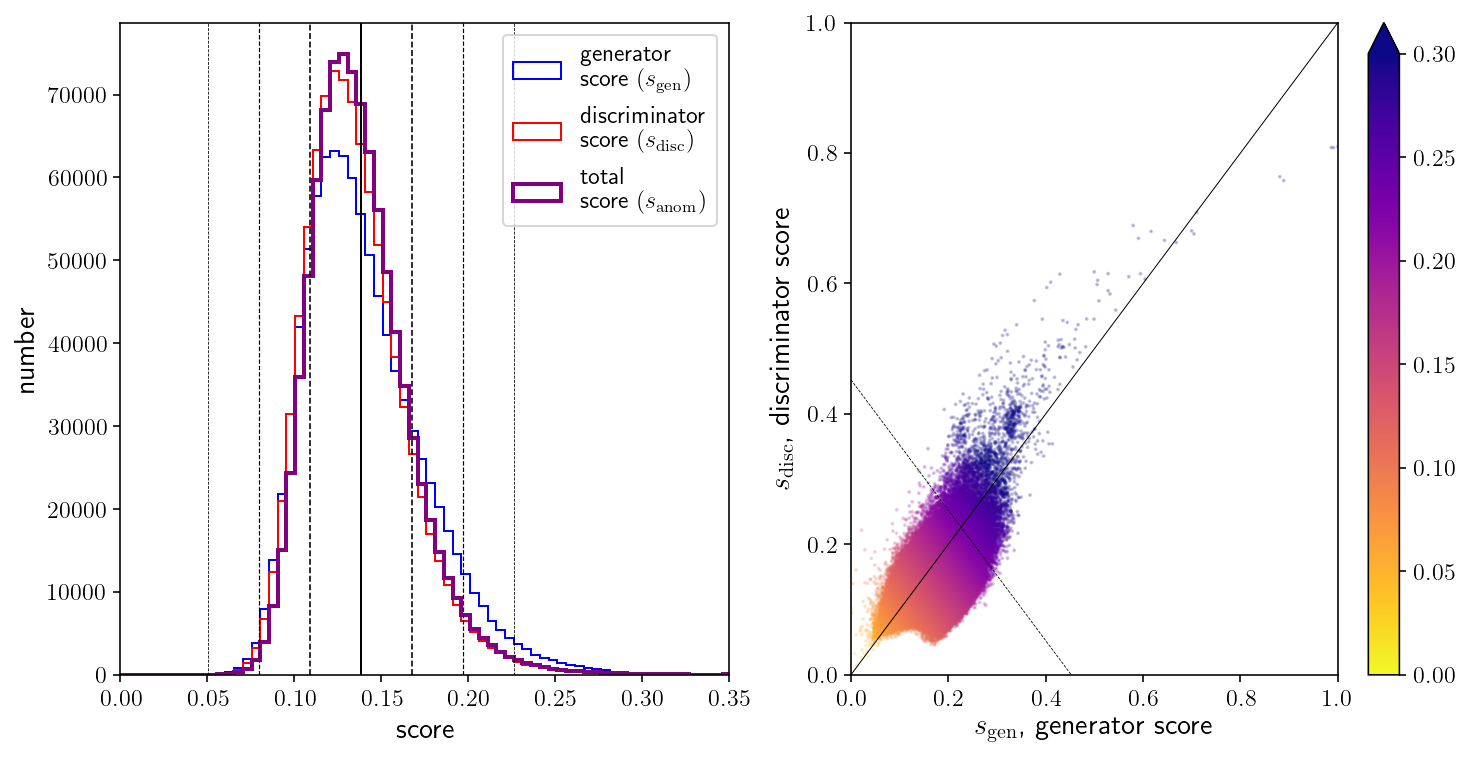

In [79]:
saveto = f'{plot_dir}/anomaly_dist.png'
plot_anomaly_dist(gen_scores, disc_scores, scores, saveto=saveto)

In [80]:
xmax = 0.35
offplot = np.where(np.array(scores) > xmax)[0]
n_offplot = len(offplot)
print(f"Number of objects off plot with scores>{xmax}: {n_offplot}")

Number of objects off plot with scores>0.35: 385


# umaps updated with new anomaly score

In [48]:
def plot_umap(embedding, saveto=None, highlight_arrs=None, highlight_colors=None, 
              highlight_markers=None, cmap='plasma_r', boxes=None, box_colors=None, 
              figsize=(8,7), colorby=None, vmin=None, alpha=0.2, s=6):
    e1, e2, cby, idxs = embedding
    if colorby is None:
        colorby = cby

    if vmin is None:
        vmin = min(colorby)
    vmax = 0.4*max(colorby)
    
    plt.figure(figsize=figsize)
    plt.scatter(e1, e2, marker='.', c=colorby, cmap=cmap, s=s, vmin=vmin, vmax=vmax, alpha=alpha)
    
    if highlight_arrs is not None:
        if np.array(highlight_arrs).ndim==1:
            highlight_arrs = [highlight_arrs]
        for i, highlight_ids in enumerate(highlight_arrs):
            argidxs = [np.where(idxs==hi)[0][0] for hi in highlight_ids]
            plt.scatter(e1[argidxs], e2[argidxs], marker=highlight_markers[i], c=colorby[argidxs], 
                            edgecolor=highlight_colors[i], lw=2, 
                            cmap=cmap, s=270, vmin=vmin, vmax=vmax)
            
    if boxes is not None:
        for i, box in enumerate(boxes):
            amin, amax, bmin, bmax = boxes[i]
            width = amax - amin
            height = bmax - bmin
            rect = matplotlib.patches.Rectangle((amin,bmin),width,height,linewidth=2,
                                                edgecolor=box_colors[i],facecolor='none')
            ax = plt.gca()
            ax.add_patch(rect)
        
    plt.xlabel('umap A')
    plt.ylabel('umap B')

    cbar = plt.colorbar(extend='max')
    cbar.set_label(r'$s_\mathrm{anom}$, anomaly score', rotation=270, labelpad=18)
    cbar.set_alpha(1)
    cbar.draw_all()
    
    plt.gca().set_aspect('equal', 'datalim')
    
    if saveto:
        plt.savefig(saveto, bbox_inches='tight')

In [49]:
# make purple colormap
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Purples')
cmap_purp = truncate_colormap(cmap, 0.25, 1.0)

### 100k

In [85]:
embed_dir = "/scratch/ksf293/kavli/anomaly/results/embeddings"
base_dir = '/scratch/ksf293/kavli/anomaly'

taga = 'gri_100k'
umap_tag = '_nn5md0.1'
#auto_tag = '_model29500_latent16'
auto_tag = '_model16000_latent64'

results_fn = f'{base_dir}/results/results_{taga}.h5'
res = h5py.File(results_fn, 'r')
scores = res['anomaly_scores_norm']

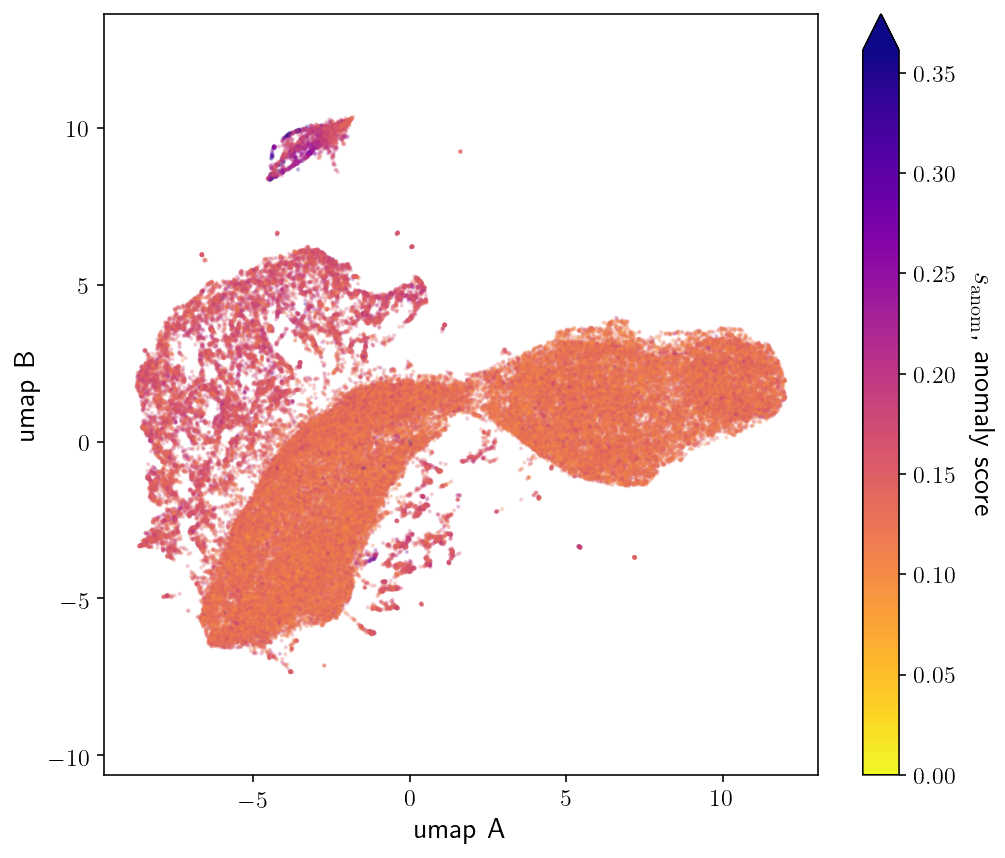

In [86]:
embedding = np.load(f"{embed_dir}/embedding_umap_reals_{taga}{umap_tag}.npy")
plot_umap(embedding, colorby=scores, vmin=0, saveto=f'{plot_dir}/umap_{taga}_reals.png')

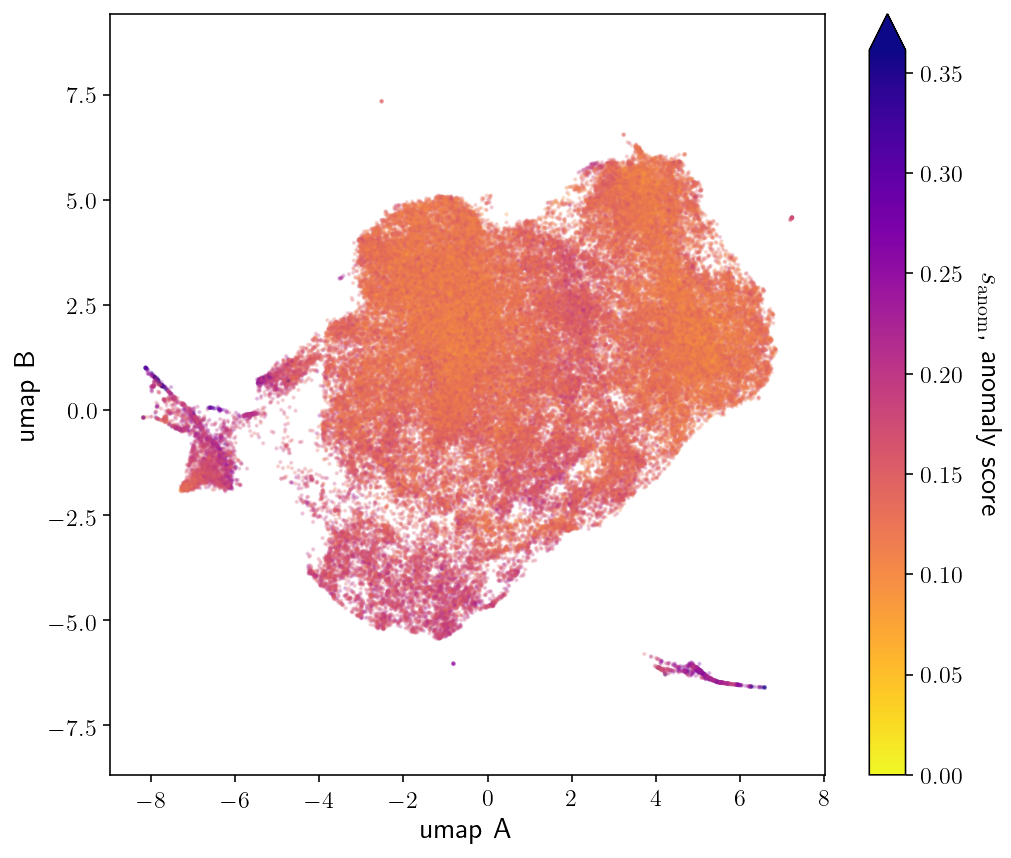

In [87]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}_reals{umap_tag}.npy", allow_pickle=True)
plot_umap(embedding, colorby=scores, vmin=0, saveto=f'{plot_dir}/umap_{taga}_reals_auto.png')

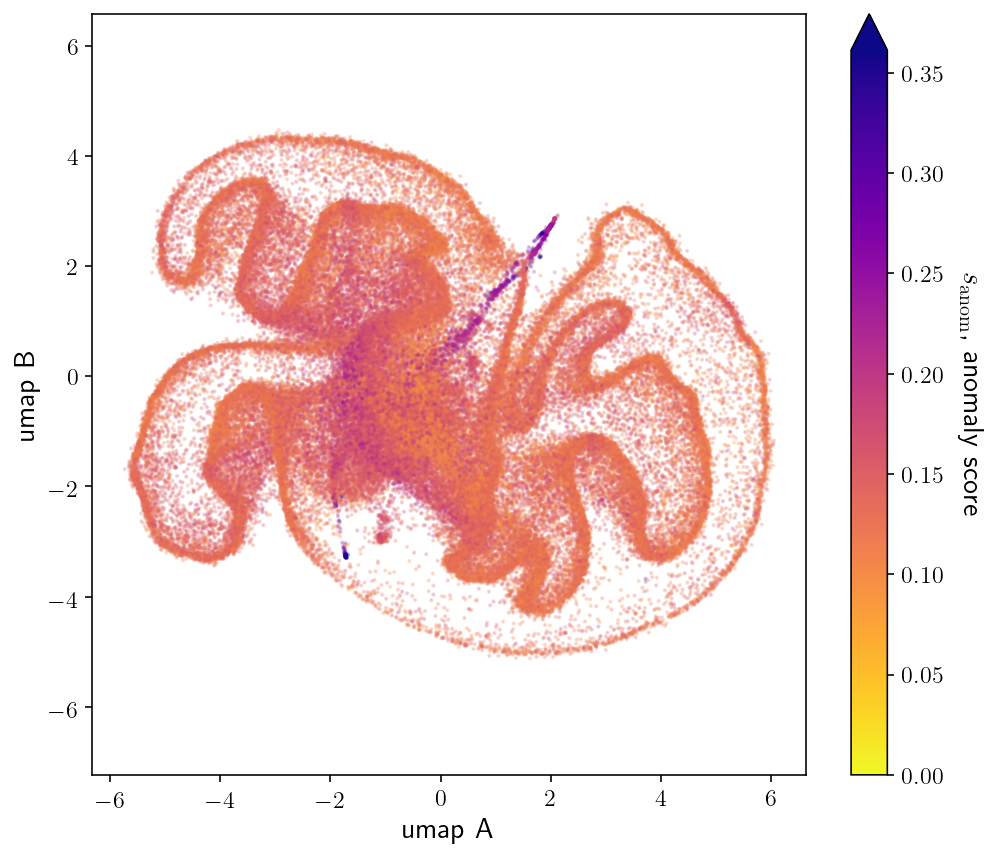

In [88]:
embedding = np.load(f"{embed_dir}/embedding_umap_residuals_{taga}{umap_tag}.npy")
plot_umap(embedding, colorby=scores, vmin=0, saveto=f'{plot_dir}/umap_{taga}_resids.png')

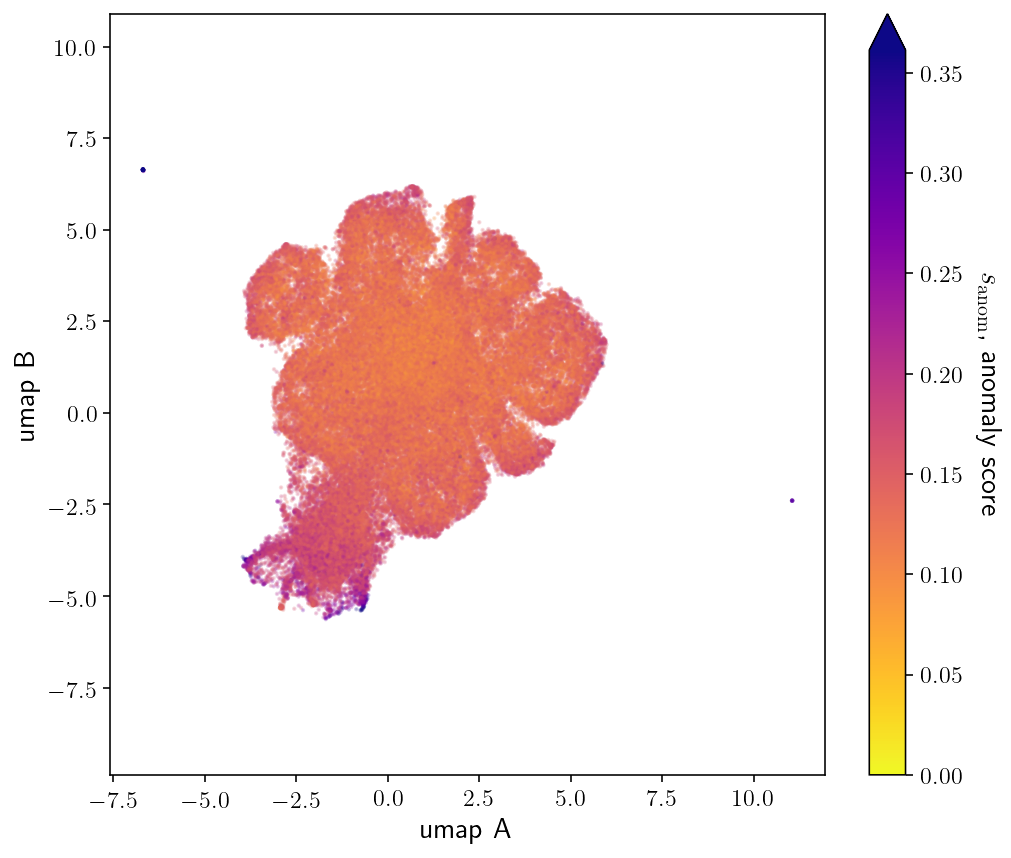

In [89]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}_residuals{umap_tag}.npy", allow_pickle=True)
plot_umap(embedding, colorby=scores, vmin=0, saveto=f'{plot_dir}/umap_{taga}_resids_auto.png')

### 3signorm

In [35]:
embed_dir = "/scratch/ksf293/kavli/anomaly/results/embeddings"
base_dir = '/scratch/ksf293/kavli/anomaly'

taga = 'gri_3signorm'
umap_tag = '_nn5md0.1'
auto_tag = '_model16000_latent64'

results_fn = f'{base_dir}/results/results_{taga}.h5'
res = h5py.File(results_fn, 'r')
scores = res['anomaly_scores_norm']

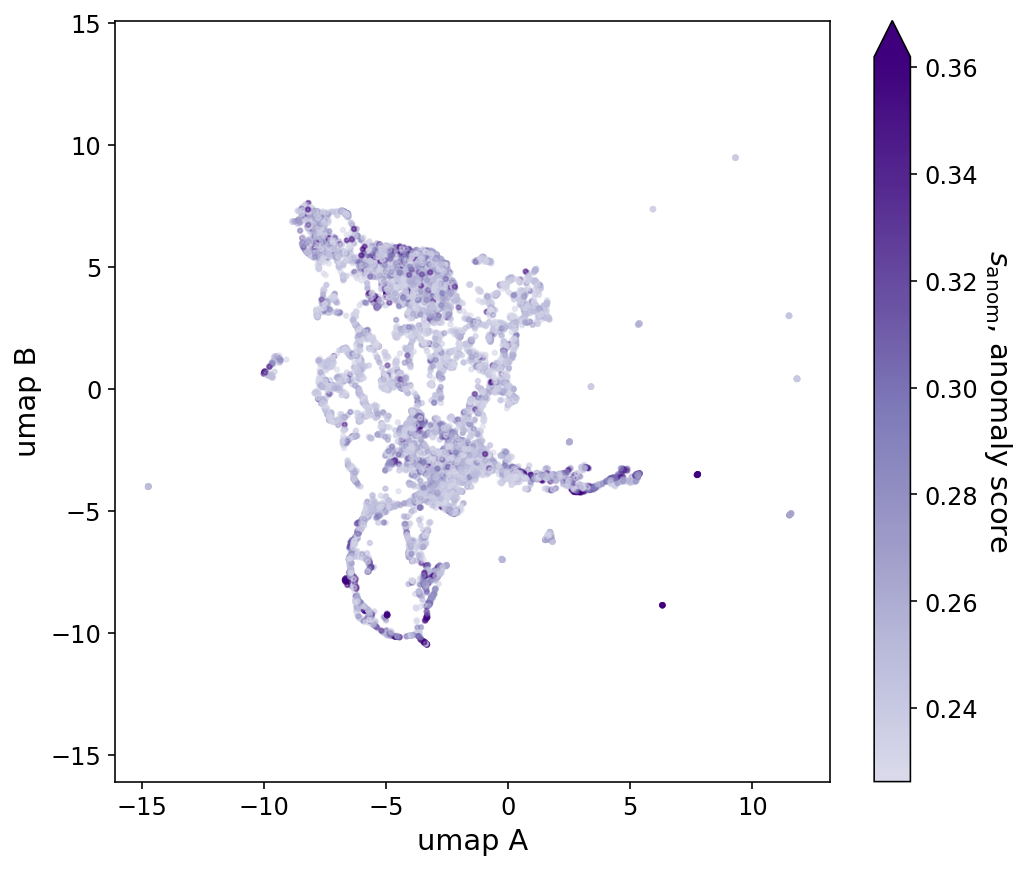

In [47]:
embedding = np.load(f"{embed_dir}/embedding_umap_reals_{taga}{umap_tag}.npy")
saveto = f'{plot_dir}/umap_{taga}_reals.png'
plot_umap(embedding, colorby=scores, saveto=saveto, cmap=cmap_purp, alpha=0.5, s=20)

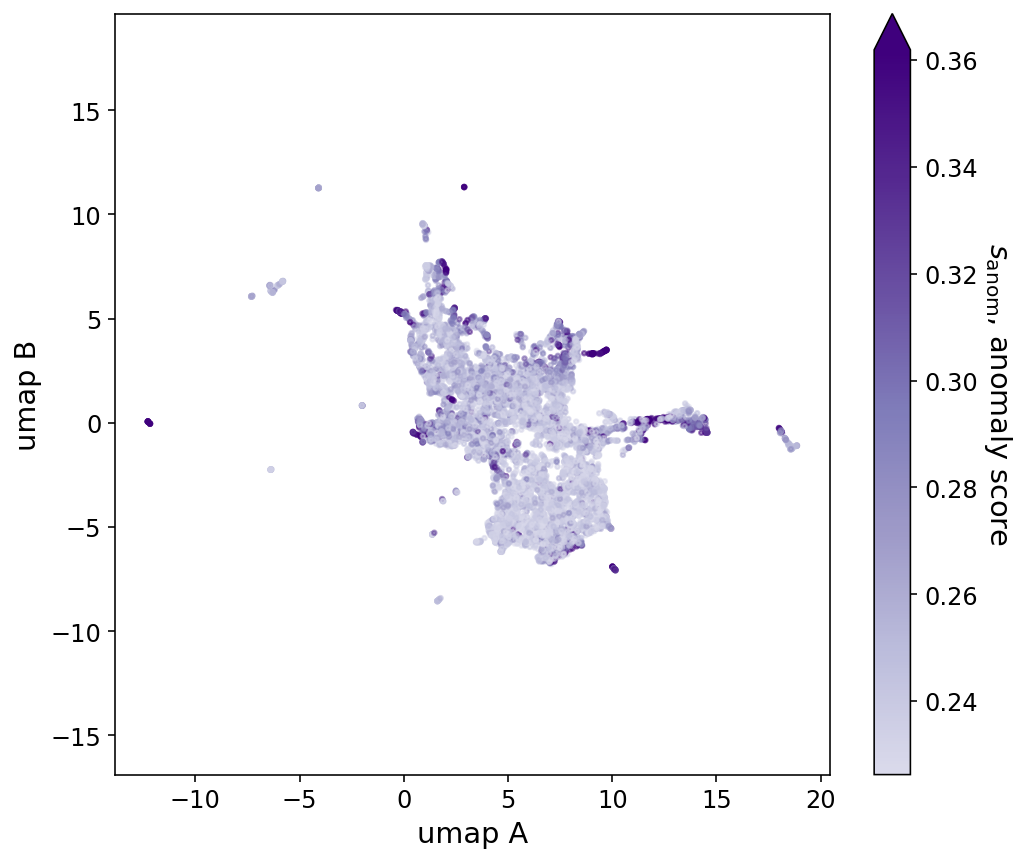

In [43]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}_reals{umap_tag}.npy", allow_pickle=True)
saveto = f'{plot_dir}/umap_{taga}_reals_auto.png'
plot_umap(embedding, colorby=scores, saveto=saveto, cmap=cmap_purp, alpha=0.5, s=20)

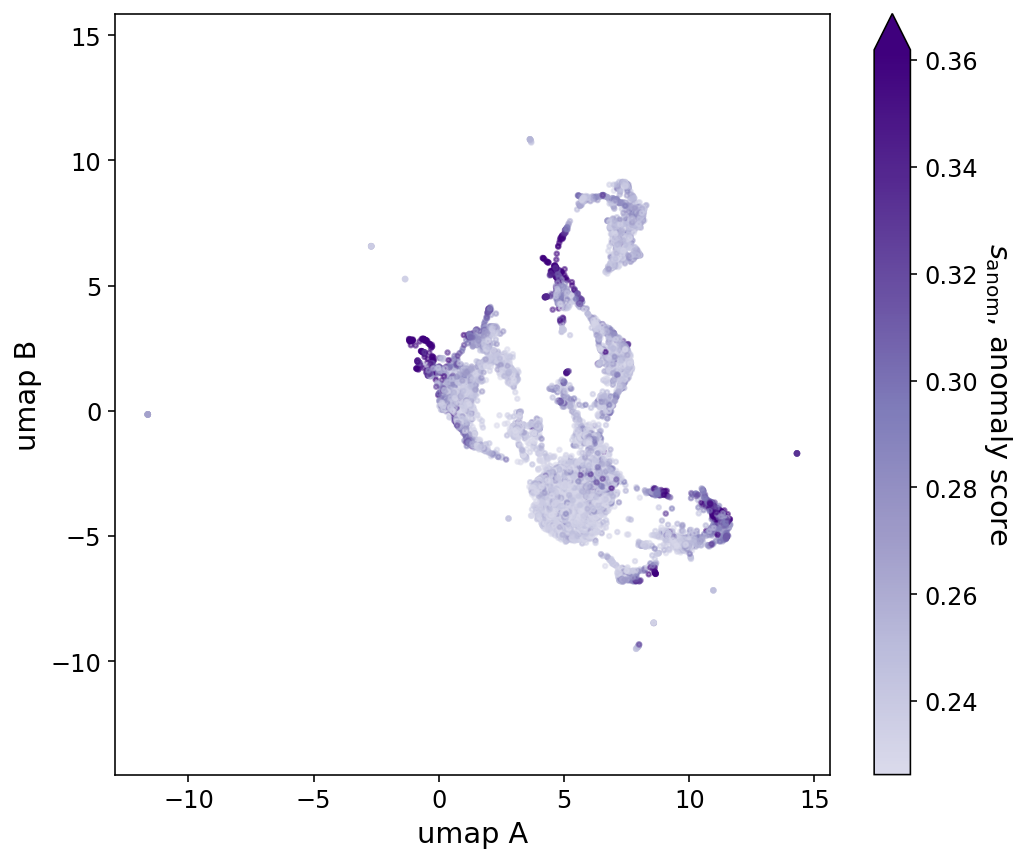

In [50]:
embedding = np.load(f"{embed_dir}/embedding_umap_residuals_{taga}{umap_tag}.npy")
saveto = f'{plot_dir}/umap_{taga}_resids.png'
plot_umap(embedding, colorby=scores, saveto=saveto, cmap=cmap_purp, alpha=0.5, s=20)

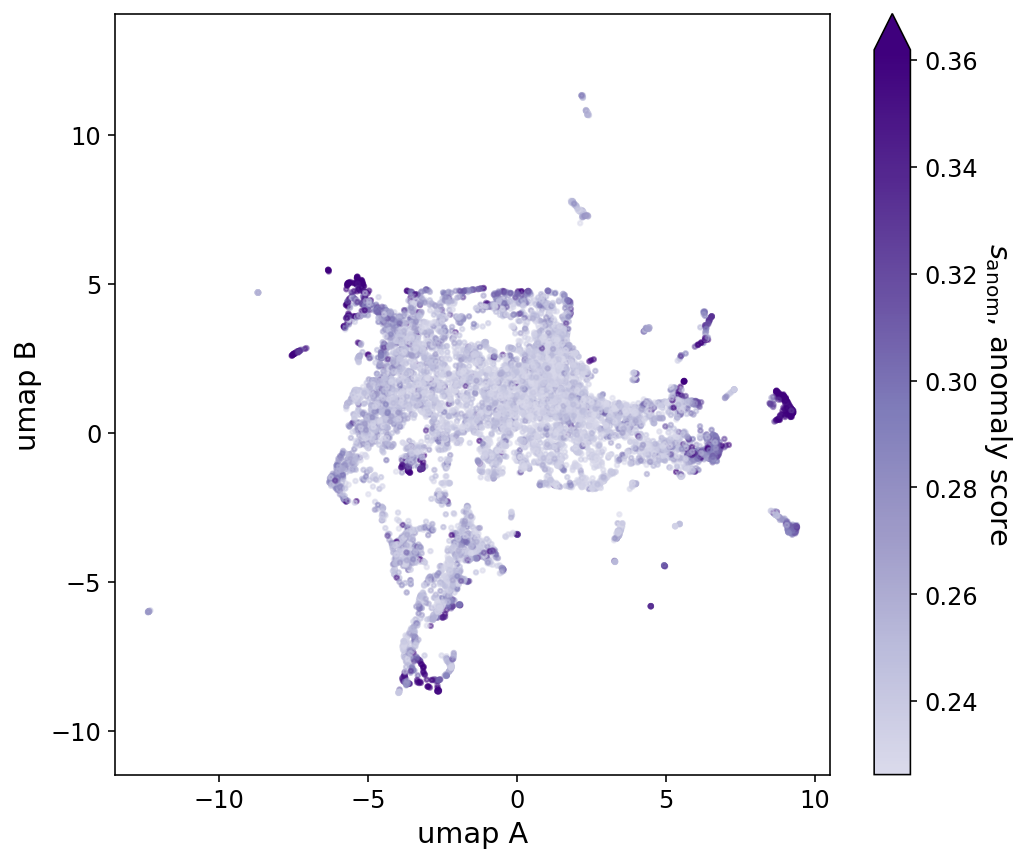

In [41]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}_residuals{umap_tag}.npy", allow_pickle=True)
saveto = f'{plot_dir}/umap_{taga}_resids_auto.png'
plot_umap(embedding, colorby=scores, saveto=saveto, cmap=cmap_purp, alpha=0.5, s=20)

## gen vs disc scores

In [36]:
tag = 'gri'
imdict_fn = f'{base_dir}/data/idxdicts_h5/idx2imloc_{tag}.npy'
resdict_fn = f'{base_dir}/data/idxdicts_h5/idx2resloc_{tag}.npy'
idx2imloc = np.load(imdict_fn, allow_pickle=True).item()
idx2resloc = np.load(resdict_fn, allow_pickle=True).item()

In [37]:
from astropy.visualization import make_lupton_rgb
def luptonize(x, rgb_q=15, rgb_stretch=0.5, rgb_min=0):
    if x.ndim==3:
        x = make_lupton_rgb(x[:,:,2], x[:,:,1], x[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
    elif x.ndim==4:
        x = np.array([make_lupton_rgb(xi[:,:,2], xi[:,:,1], xi[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
                      for xi in x])
    else:
        raise ValueError(f"Wrong number of dimensions! Gave {x.ndim}, need 3 or 4")
    return x

In [104]:
def plot_ims(ids, nrows, ncols, saveto=None, headers=None):
    assert len(ids)<=nrows*ncols, "bad rows/cols for number of ids!"
    
    nside = 96
    subsize = 2
    fig, axarr = plt.subplots(nrows,ncols,figsize=(ncols*subsize,nrows*subsize))
    plt.subplots_adjust(hspace=0.2, wspace=0.05)
    plt.rc('text', usetex=True)
    
    count = 0
    for i in range(nrows):
        for j in range(ncols):
            idx = ids[count]
            imloc = idx2imloc[idx]
            im = imarr['images'][imloc]
            resloc = idx2resloc[idx]
            obj_id = res['object_ids'][resloc]
            if nrows==1 and ncols==1:
                ax = axarr
            elif nrows==1:
                ax = axarr[j]
            elif ncols==1:
                ax = axarr[i]
            else:
                ax = axarr[i][j]
            title = f"ID: {obj_id}"
            ax.set_title(title, fontsize=8)
            ax.imshow(luptonize(im))
            ax.set_xticks([])
            ax.set_yticks([])
            
            if headers is not None and i==0:
                ax.text(nside/2,-nside/4,headers[j], size=16, horizontalalignment='center')
                
            count += 1
            if count>=len(ids):
                break
                
        if count>=len(ids):
            break
                
    if saveto:
        plt.savefig(saveto, bbox_inches='tight')#, pad_inches=0)

In [93]:
tag = 'gri'
base_dir = '/scratch/ksf293/kavli/anomaly'
results_fn = f'{base_dir}/results/results_{tag}.h5'
res = h5py.File(results_fn, 'r')

gen_scores = res['gen_scores_norm'][:]
disc_scores = res['disc_scores_norm'][:]
scores = res['anomaly_scores_norm'][:]
idxs = res['idxs'][:]

In [94]:
thresh_3sig = np.mean(scores) + 3*np.std(scores)
gdratio = gen_scores/disc_scores

In [95]:
ratio_bins = np.array([0.4,0.6,0.7,0.9,1.1,1.3,1.4,1.6])
print(ratio_bins)
ratio_locs_binned = []
for i in range(len(ratio_bins)-1):
    locs_inbin = np.where((scores > thresh_3sig) & 
                          (ratio_bins[i] <= gdratio) & 
                          (gdratio < ratio_bins[i+1]))[0]
    ratio_locs_binned.append(locs_inbin)
ratio_bin_means = 0.5*(ratio_bins[:-1]+ratio_bins[1:])
print([round(r,2) for r in ratio_bin_means])

[0.4 0.6 0.7 0.9 1.1 1.3 1.4 1.6]
[0.5, 0.65, 0.8, 1.0, 1.2, 1.35, 1.5]


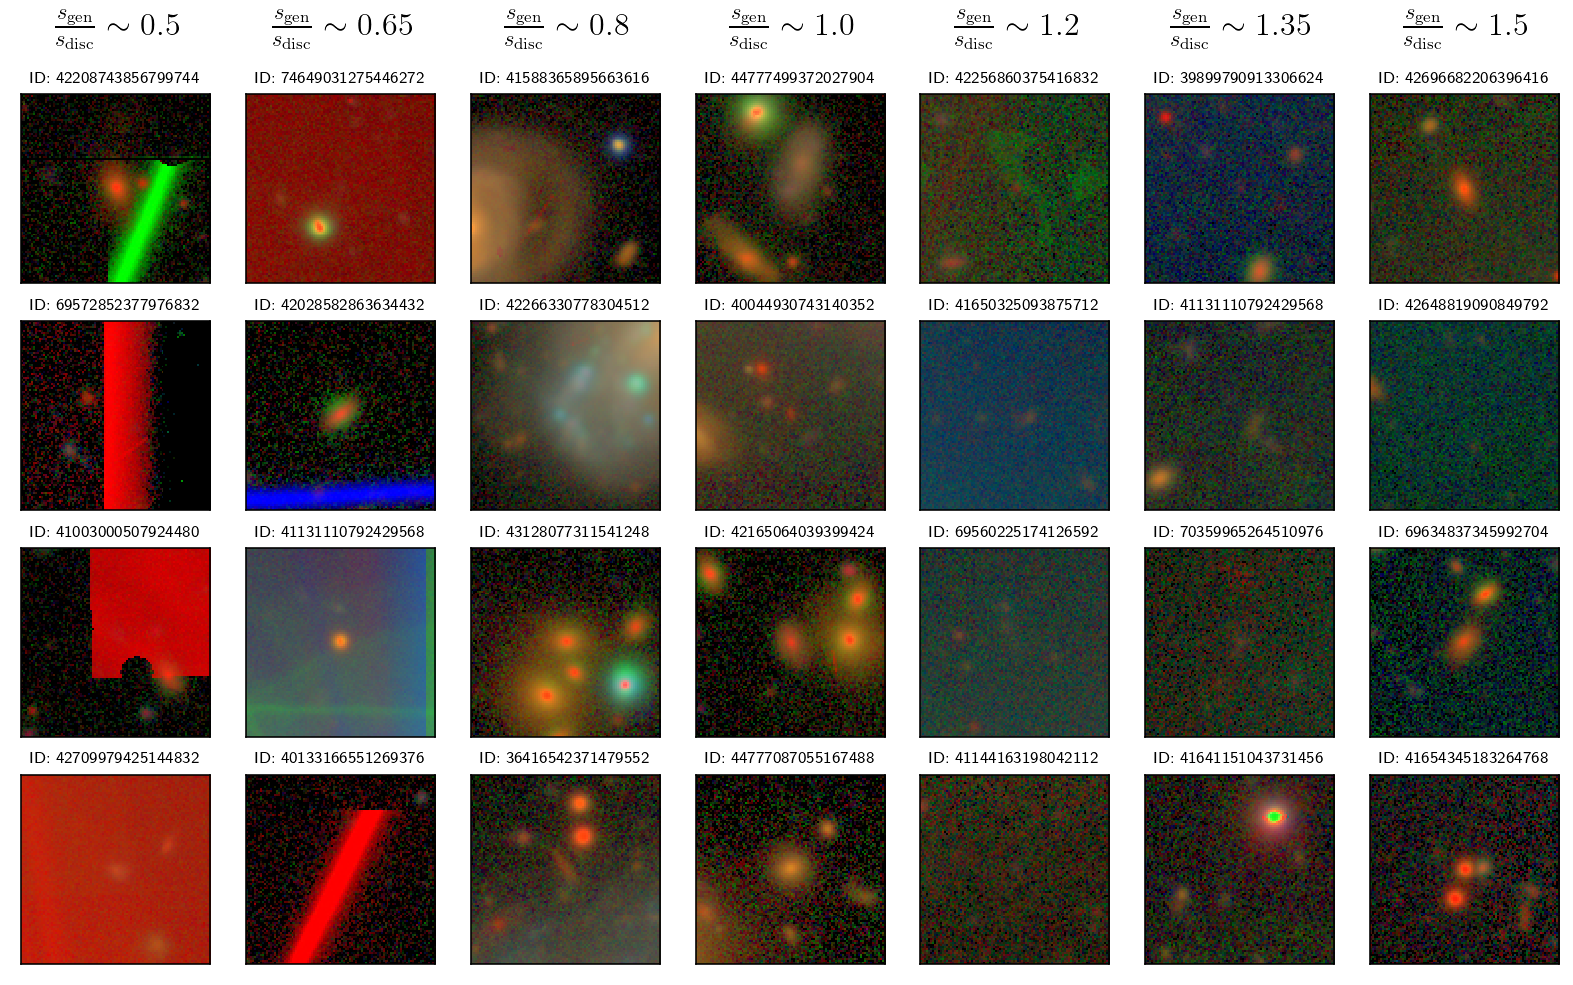

In [96]:
seed = 37 #41, 37
np.random.seed(seed)
ncols = 4
nrows = len(ratio_bins)-1
ratio_sample_idxs = np.empty((nrows, ncols), dtype=int)
headers = []
headers = [r'$\frac{s_\mathrm{gen}}{s_\mathrm{disc}}\sim'+str(round(r,2))+'$' for r in ratio_bin_means]
for i in range(len(ratio_bins)-1):
    ratio_sample_idxs[i] = np.random.choice(idxs[ratio_locs_binned[i]], ncols, replace=False)
    
saveto = f'{plot_dir}/gen_disc_ratio.png'
plot_ims(ratio_sample_idxs.T.flatten(), ncols, nrows, headers=headers, saveto=saveto)

# overlap between interesting anomalies bw 3sig and 3signorm

In [8]:
tag = 'gri_3signorm'
base_dir = '/scratch/ksf293/kavli/anomaly'
results_fn = f'{base_dir}/results/results_{tag}.h5'
res = h5py.File(results_fn, 'r')

idxs_3signorm = res['idxs'][:]

In [16]:
# clusters of interesting objects in umap
# currently only in neurips paper, not main
extended_purple = [105685, 80217, 539520]#, 378977, 43986, 355424]
mergers_upper = [157767,147100,105162]
blue_dots_isolated = [137543,168508,153414]#,267827]
blue_sf = [461525, 86279,707620]#,782291]
clusters_all = np.array(extended_purple + mergers_upper + blue_dots_isolated + blue_sf)

In [20]:
# interesting anomalies in final figure
bluecore_ids = [936569, 941128, 782291, 896225,404105,549909] #935055
sf_ids = [461525, 461522, 702705, 707620, 402208, 86279]
tidal_ids = [406992,105162,232476,402855,112806,402153] # 936581 in COSMOS
purple_ids = [631495, 60339,293191, 105685, 80217, 539520]
unknown_ids = [404340, 402594,732306] #66001
interesting_all = np.array(bluecore_ids + sf_ids + tidal_ids + purple_ids + unknown_ids)

In [34]:
in_3signorm_clusters = [True if idx in idxs_3signorm else False for idx in clusters_all]
in_3signorm_interesting = [True if idx in idxs_3signorm else False for idx in interesting_all]

[137543 153414]


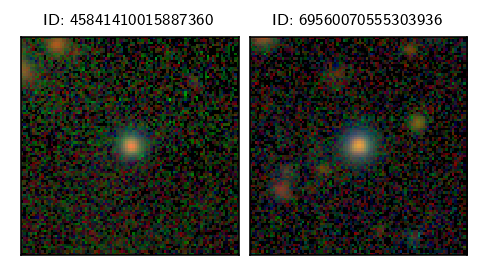

In [43]:
clusters_not_in_3signorm = clusters_all[~np.array(in_3signorm_clusters)]
print(clusters_not_in_3signorm)
plot_ims(clusters_not_in_3signorm, 1, len(clusters_not_in_3signorm))

[936569 404105]


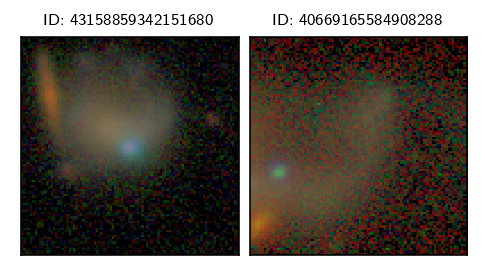

In [44]:
interesting_not_in_3signorm = interesting_all[~np.array(in_3signorm_interesting)]
print(interesting_not_in_3signorm)
plot_ims(interesting_not_in_3signorm, 1, len(interesting_not_in_3signorm))
# first was from COSMOS! so second is only one that actually didnt make cut. and it does look p boring :) 

## interesting anomalies, 3signorm

In [189]:
#(935055, 936569) are COSMOS field, not necessarily 3sig 
bluecore_ids = [936569, 941128, 782291, 896225,817345,549909] #935055; 404105 (not in 3signorm)
sf_ids = [461525, 461522, 702705, 707620, 402208, 86279] #53142
tidal_ids = [406992,105162,232476,402855,476493,304993] #402153,112806 # 936581 in COSMOS
purple_ids = [631495, 60339,293191, 105685, 80217, 752254] #539520] 
unknown_ids = [404340, 402594,732306] #66001

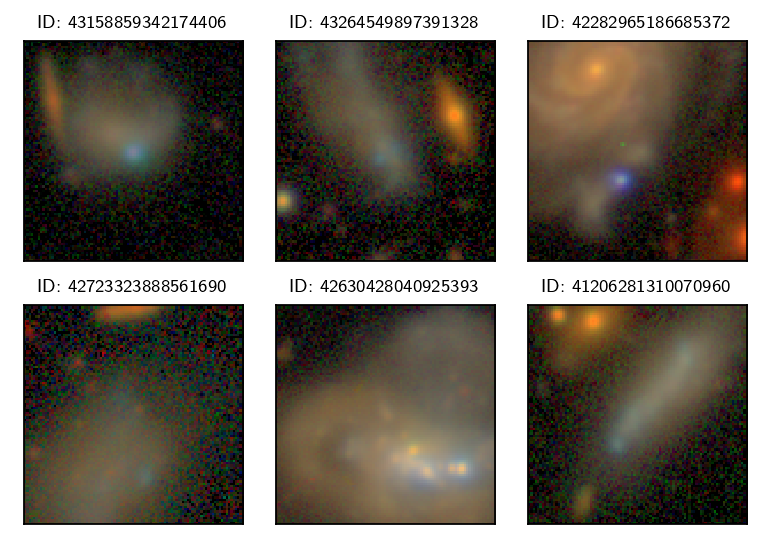

In [184]:
plot_ims(bluecore_ids, 2, 3, saveto=f'{plot_dir}/anomalies_bluecore.png')

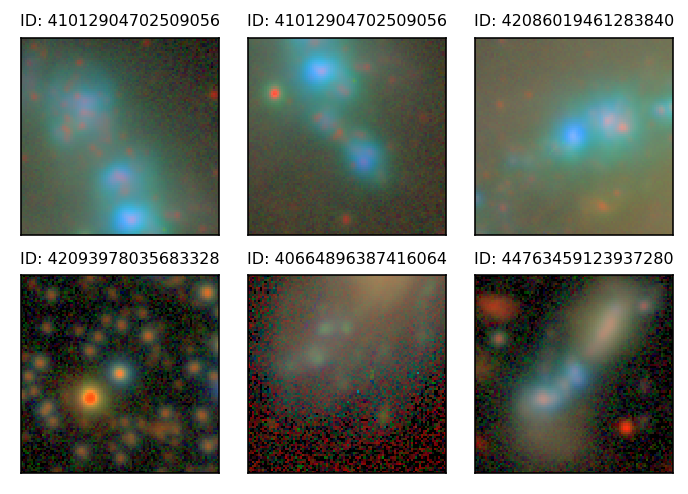

In [40]:
plot_ims(sf_ids, 2, 3, saveto=f'{plot_dir}/anomalies_starforming.png')

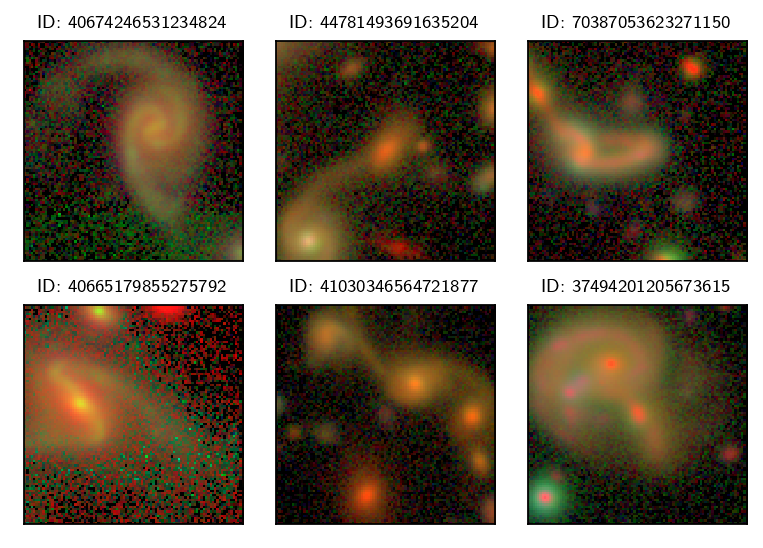

In [188]:
plot_ims(tidal_ids, 2, 3, saveto=f'{plot_dir}/anomalies_tidalfeatures.png')

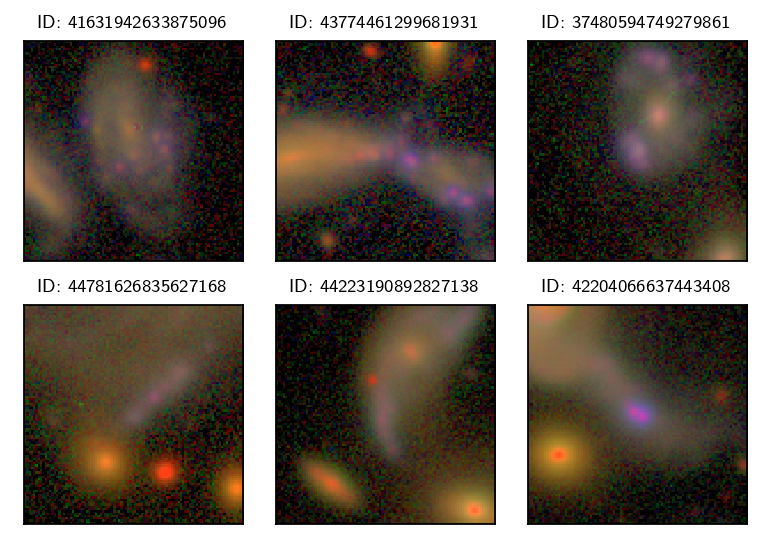

In [190]:
plot_ims(purple_ids, 2, 3, saveto=f'{plot_dir}/anomalies_purple.png')

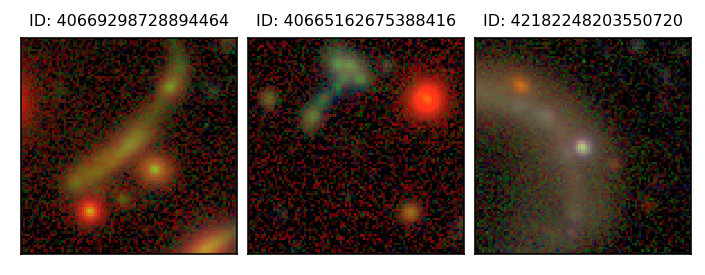

In [49]:
plot_ims(unknown_ids, 1, 3, saveto=f'{plot_dir}/anomalies_unknown.png')

# umap w boxes

In [65]:
def get_residual(im, recon):
    im = np.array(im)
    reals = im.reshape((96,96,-1))
    #reals = luptonize(reals).astype('int')
    recon = np.array(recon)
    recon = recon.reshape((96,96,-1)).astype('int')
    resid = abs(im-recon)
    return resid

In [163]:
def plot_recons(ids, saveto=None, border_color=None):
    nims = len(ids)
    subsize = 2
    fig, axarr = plt.subplots(3,nims,figsize=(nims*subsize,3*subsize), edgecolor=border_color)
    plt.subplots_adjust(hspace=0.02, wspace=0.1)
    count = 0
    for i in range(nims):
        idx = ids[i]
        
        loc = idx2imloc[idx]
        im = luptonize(imarr['images'][loc])
        
        rloc = idx2resloc[idx]
        recon = res['reconstructed'][rloc]
        score = float(res['anomaly_scores_norm'][rloc])
        obj_id = res['object_ids'][rloc]
        resid = get_residual(im, recon)
        
        ax0 = axarr[0][i]
        ax1 = axarr[1][i]
        ax2 = axarr[2][i]
        title = r'''ID: {}
$s_\mathrm{{anom}}$ = {:.4f}'''.format(obj_id, score)
        ax0.set_title(title, fontsize=8)
        ax0.imshow(im)
        ax1.imshow(recon)
        ax2.imshow(resid)
        
        if i==0:
            fsize=13
            ax0.set_ylabel("real",fontsize=fsize)
            ax1.set_ylabel("reconstructed",fontsize=fsize)
            ax2.set_ylabel("residual",fontsize=fsize)
        
        for ax in [ax0, ax1, ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
    
    if border_color is not None:
        fig.patch.set_edgecolor(border_color)  
        fig.patch.set_linewidth('4') 
        
    if saveto:
        plt.savefig(saveto, bbox_inches='tight', edgecolor=border_color)#, pad_inches=0)

In [50]:
def get_idxs_in_box(embedding, umap_range, n_ims, seed=42):
    
    amin, amax, bmin, bmax = umap_range
    e1, e2, colorby, idxs = embedding
    idxs_in_box = [idxs[i] for i in range(len(e1)) if amin<e1[i]<amax and bmin<e2[i]<bmax]
    print(len(idxs_in_box))
    np.random.seed(seed=seed)
    idxs_subsample = np.random.choice(idxs_in_box, size=n_ims, replace=False)
    
    return idxs_subsample

In [63]:
tag = 'gri'
base_dir = '/scratch/ksf293/kavli/anomaly'
results_fn = f'{base_dir}/results/results_{tag}.h5'
res = h5py.File(results_fn, 'r')

In [56]:
embed_dir = "/scratch/ksf293/kavli/anomaly/results/embeddings"
taga = 'gri_3signorm'
umap_tag = '_nn5md0.1'
auto_tag = '_model16000_latent64_residuals'
embedding_3signorm = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}{umap_tag}.npy", allow_pickle=True)

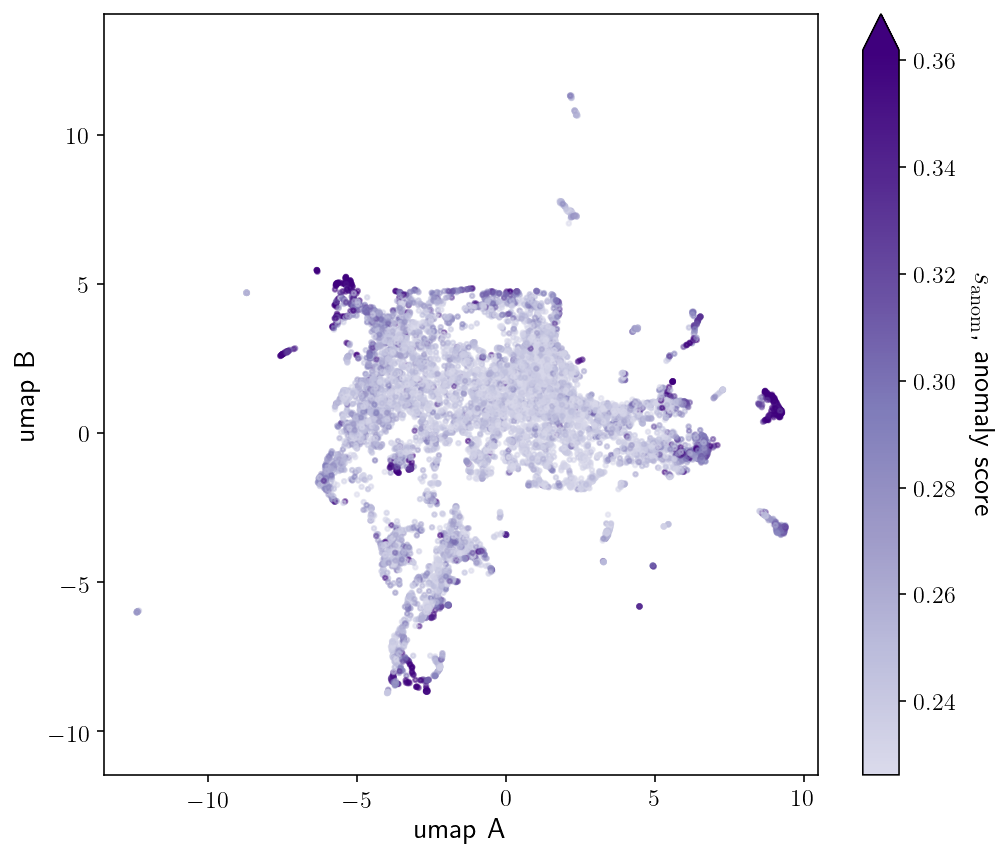

In [57]:
plot_umap(embedding_3signorm, cmap=cmap_purp, alpha=0.5, s=20)

In [128]:
n_ims = 5

35


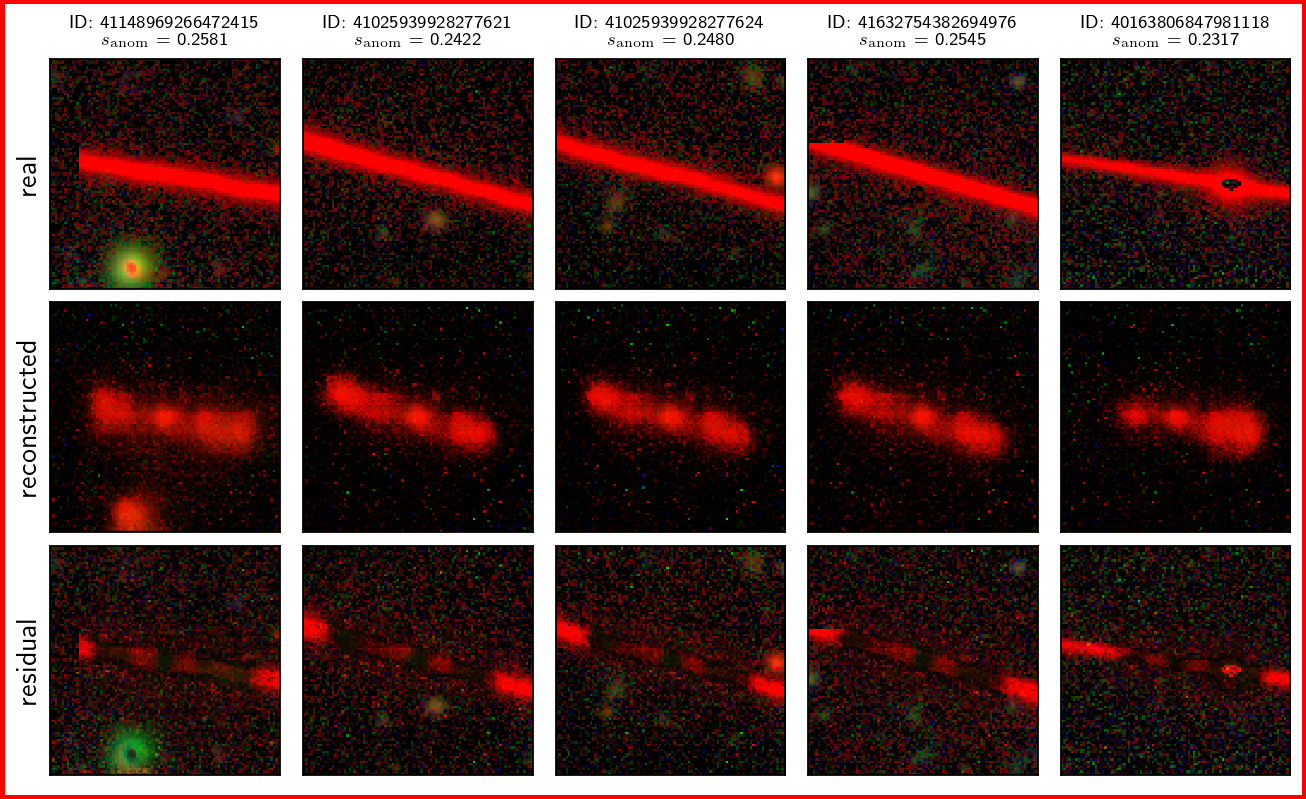

In [177]:
box_stripes = [2,3,10.5,11.5]
bcolor_stripes = 'red'
idxs_box = get_idxs_in_box(embedding_3signorm, box_stripes, n_ims, seed=39) #40: red
saveto = f'{plot_dir}/recons_box_{bcolor_stripes}.png'
plot_recons(idxs_box, border_color=bcolor_stripes, saveto=saveto)

180


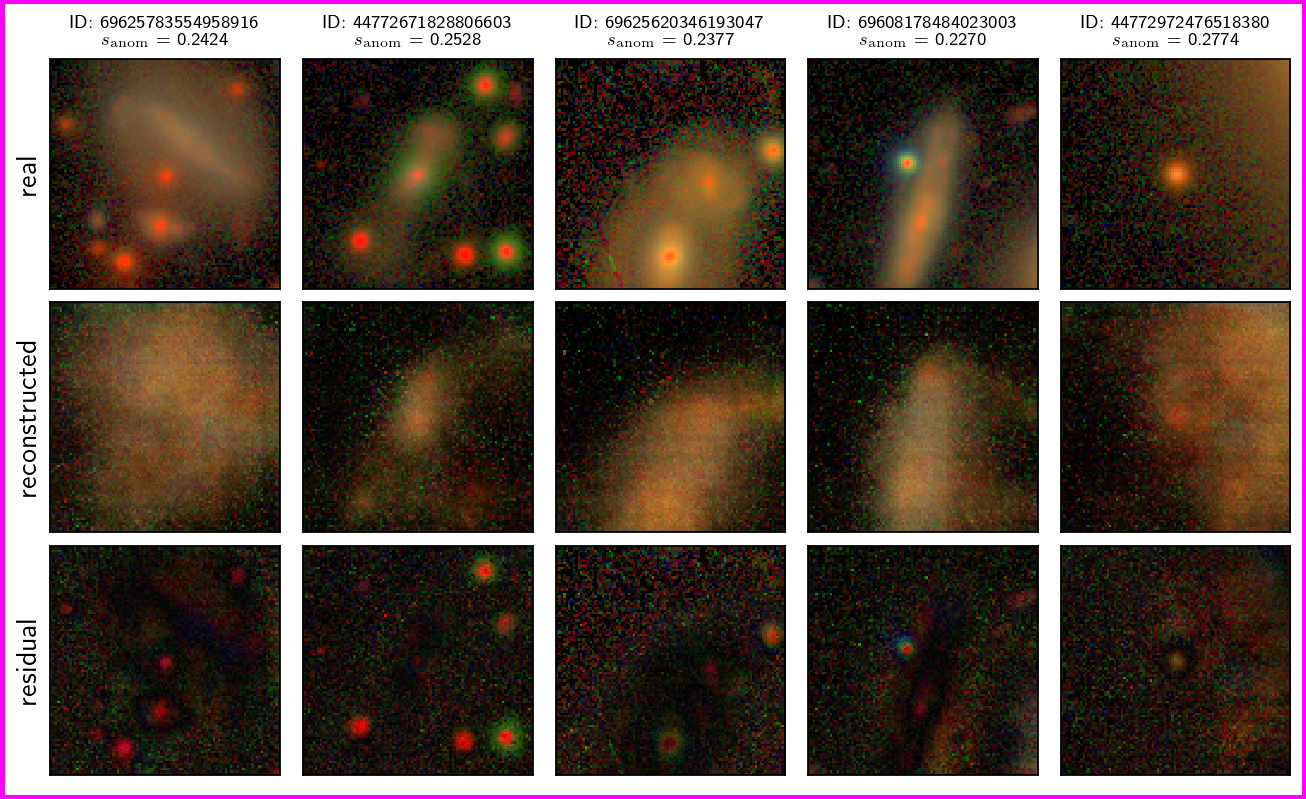

In [178]:
#box_multi = [1,2,-1,0]
box_multi = [0,1,2,3]
bcolor_multi = 'magenta'
idxs_box = get_idxs_in_box(embedding_3signorm, box_multi, n_ims, seed=39) #42, 39
saveto = f'{plot_dir}/recons_box_{bcolor_multi}.png'
plot_recons(idxs_box, border_color=bcolor_multi, saveto=saveto)

99


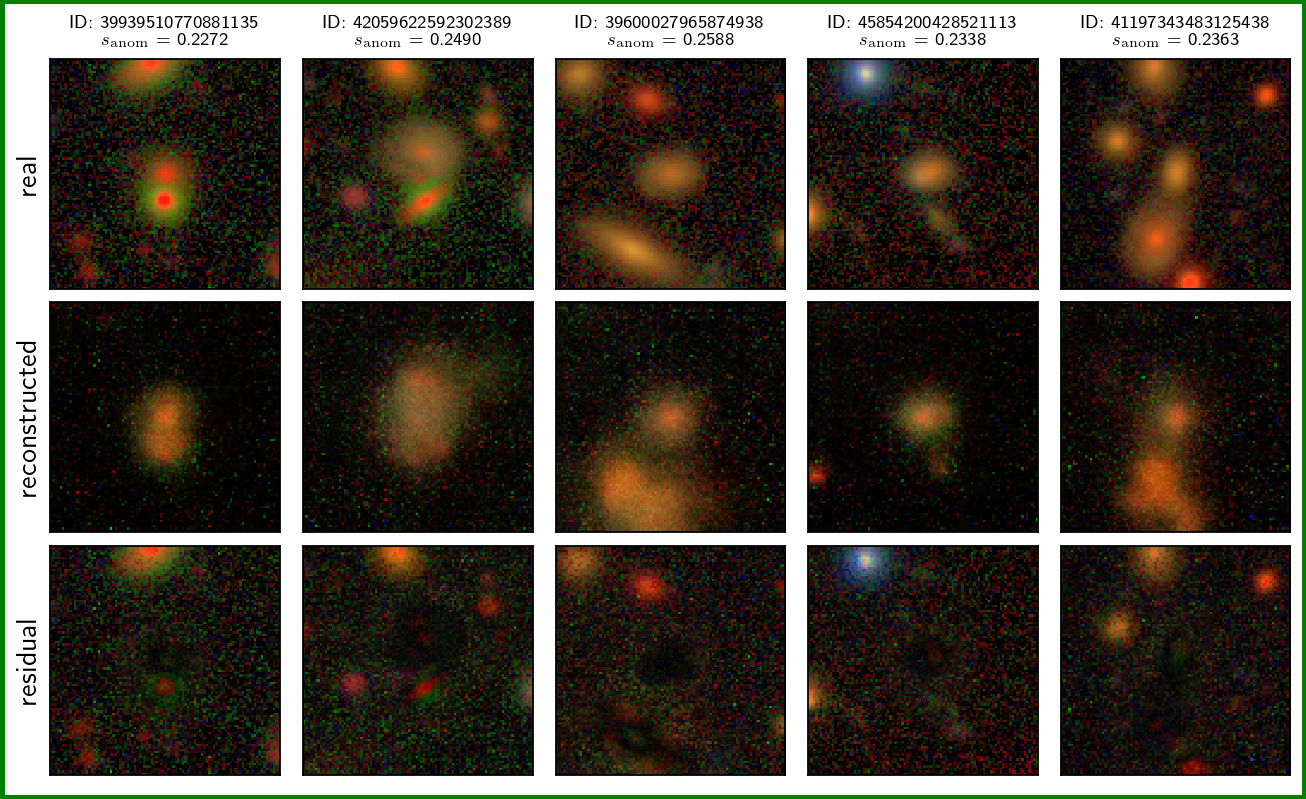

In [179]:
box_many = [2,3,-2,-1]
bcolor_many = 'green'
idxs_box = get_idxs_in_box(embedding_3signorm, box_many, n_ims, seed=40) #40 - weird companions
saveto = f'{plot_dir}/recons_box_{bcolor_many}.png'
plot_recons(idxs_box, border_color=bcolor_many, saveto=saveto)

120


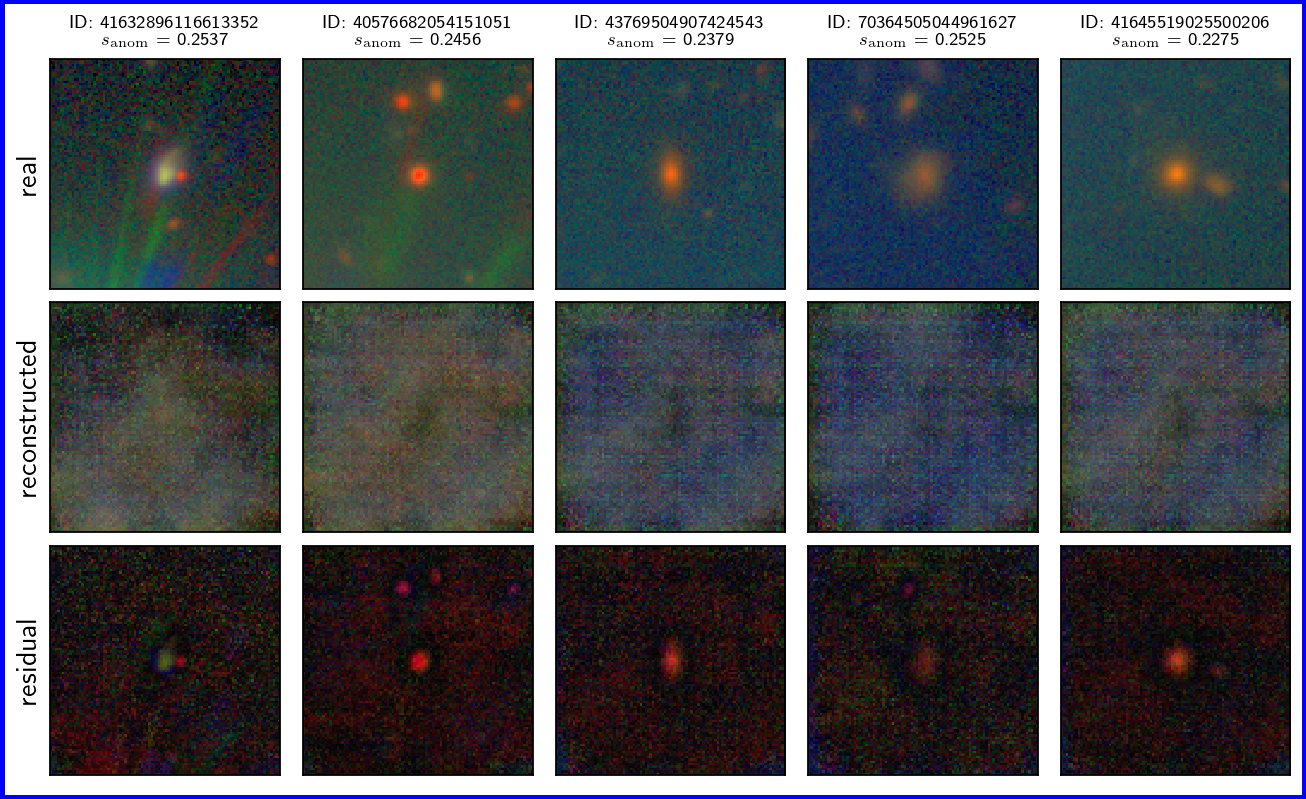

In [180]:
box_blue = [-4,-3,-4.5,-3.5]
bcolor_blue = 'blue'
idxs_box = get_idxs_in_box(embedding_3signorm, box_blue, n_ims, seed=40) #40
saveto = f'{plot_dir}/recons_box_{bcolor_blue}.png'
plot_recons(idxs_box, border_color=bcolor_blue, saveto=saveto)

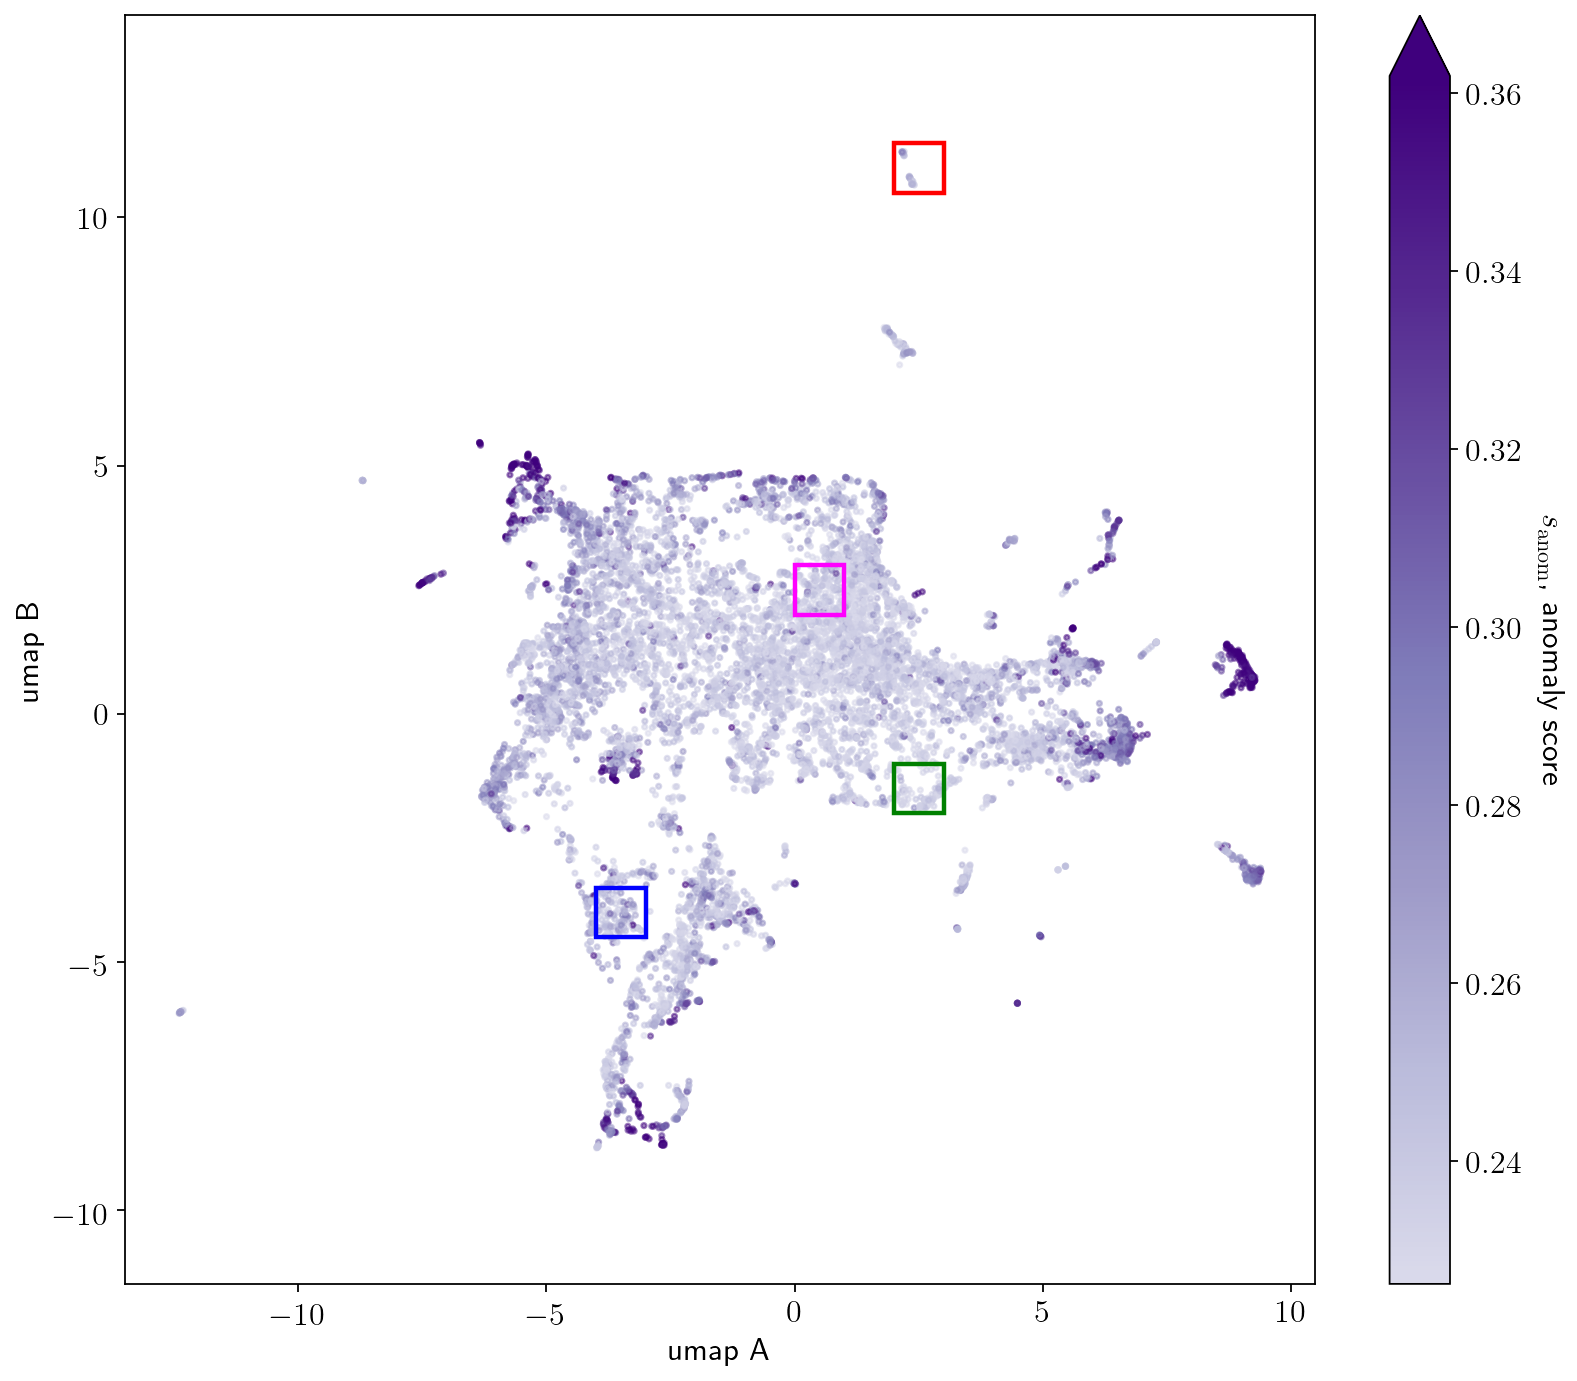

In [182]:
boxes = [box_stripes, box_multi, box_many, box_blue]
bcolors = [bcolor_stripes, bcolor_multi, bcolor_many, bcolor_blue]
saveto = f'{plot_dir}/umap_3signorm_resids_auto_boxes.png'
plot_umap(embedding_3signorm, boxes=boxes, box_colors=bcolors, cmap=cmap_purp, figsize=(12,10.5), 
          alpha=0.5, s=20, saveto=saveto)